
L'incorporation de mots, ou \textit{word embedding} en anglais, est une technique fondamentale en traitement automatique du langage naturel (TALN) qui permet de représenter les mots sous forme de vecteurs numériques. Ces vecteurs capturent les relations sémantiques entre les mots, facilitant ainsi le traitement et l'analyse automatiques du langage.

En combinant les incorporations de mots avec un Perceptron Multicouche (MLP), il est possible d'effectuer une classification de texte efficace. Voici comment cela fonctionne :

1. **Incorporation de Mots** :

   Tout d'abord, chaque mot dans le texte est représenté sous forme de vecteur à l'aide d'une matrice d'incorporation, notée $ E $. Si $ V $ est la taille du vocabulaire et $ d $ est la dimension de l'incorporation, alors $ E $ est une matrice de dimension $ V \times d $.

   Mathématiquement, pour une phrase composée de mots $ w_1, w_2, \ldots, w_n $, les vecteurs d'incorporation $ \mathbf{v}_i $ de chaque mot $ w_i $ sont calculés et moyennés pour former un vecteur $ \mathbf{v}_{\text{moyen}} $ :

   $$ \mathbf{v}_{\text{moyen}} = \frac{1}{n} \sum_{i=1}^{n} E(w_i) $$

   où $ E(w_i) $ représente la $i$-ème ligne de la matrice $ E $.

2. **Perceptron Multicouche (MLP)** :

   Ensuite, le vecteur moyen $ \mathbf{v}_{\text{moyen}} $ est utilisé comme entrée pour le MLP. Le MLP est un réseau de neurones artificiels composé de plusieurs couches. Chaque neurone dans une couche est connecté à tous les neurones de la couche précédente. La sortie du MLP est une probabilité de classe.

   Mathématiquement, si $ \mathbf{x} $ est le vecteur d'entrée, $ \mathbf{W} $ représente les poids et $ \mathbf{b} $ les biais du MLP, alors la sortie $ \mathbf{y} $ du MLP est donnée par :

   $$ \mathbf{y} = \sigma(\mathbf{Wx} + \mathbf{b}) $$

   Où $ \sigma $ est une fonction d'activation.

3. **Entraînement du Modèle** :

   Le modèle est ensuite entraîné en minimisant une fonction de perte, par exemple l'entropie croisée. Cela se fait en ajustant les poids $ \mathbf{W} $ et les biais $ \mathbf{b} $ du MLP à l'aide d'un algorithme d'optimisation tel que la descente de gradient.

En combinant ces deux techniques, l'incorporation de mots et le MLP, il est possible de construire un modèle de classification de texte puissant qui est capable d'apprendre des représentations sémantiques utiles pour la tâche de classification.



In [1]:
#!pip install torchtext

In [2]:
#!pip install shap

In [3]:
#!pip install portalocker>=2.0.0

In [4]:
#!pip install scikit-plot

In [5]:

from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
from tqdm import tqdm

import gc
import re
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



from torch.utils.data import DataLoader
from torchtext.data.functional import to_map_style_dataset

from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import torchtext
import shap


In [6]:
from torchtext.datasets import AG_NEWS


train, test = AG_NEWS('.', split=('train', 'test'))

## Tokéniser des données textuelles et construire un vocabulaire
Dans cette section, nous avons d'abord créé un tokenizer en utilisant la fonction get_tokenizer(). Nous lui avons demandé de créer un tokenizer simple qui sépare les mots de la phrase. Il prend du texte en entrée et renvoie une liste de tokens/mots en sortie.

Ensuite, nous avons construit un vocabulaire en utilisant la fonction build_vocab_from_iterator(). Cette fonction renvoie une instance de Vocab qui contient une correspondance entre les mots et leurs index. Le vocabulaire associe simplement les mots/tokens à leurs index respectifs. Pour créer un vocabulaire à l'aide de la fonction build_vocab_from_iterator(), nous devons lui fournir une fonction qui produit une liste de tokens/mots. Nous avons créé une petite fonction qui prend en entrée une liste d'ensembles de données et qui parcourt en boucle tous les ensembles de données et leurs documents textuels respectifs. Pour chaque document texte, elle produit une liste de tokens/mots à l'aide de la fonction tokenizer que nous avons créée.

Après avoir rempli un vocabulaire, nous avons également imprimé la taille du vocabulaire et nous avons expliqué un exemple de la manière dont le vocabulaire associe les mots/mots à leurs index. Ces index serviront d'entrée à nos réseaux neuronaux.

In [7]:


def tokenizer(inp_str): ## This method is one way of creating tokenizer that looks for word tokens
    return re.findall(r"\w+", inp_str)

tokenizer = get_tokenizer("basic_english") ## We'll use tokenizer available from PyTorch

In [8]:
def build_vocab(datasets):
    for dataset in datasets:
        for _, text in dataset:
            yield tokenizer(text)

vocab = build_vocab_from_iterator(build_vocab([train, test]), specials=["<UNK>"])
vocab.set_default_index(vocab["<UNK>"])

In [9]:
tokens = tokenizer("Hello how are you?")
indexes = vocab(tokens)

tokens, indexes

(['hello', 'how', 'are', 'you', '?'], [12388, 355, 42, 164, 80])

##Créer des chargeurs de données (vectoriser des données textuelles)
Dans cette section, nous avons créé des chargeurs de données de formation et de test que nous utiliserons pendant le processus de formation pour parcourir les données. Pour créer les chargeurs de données, nous avons chargé à nouveau les ensembles de données de formation et de test et les avons donnés au constructeur DataLoader() en tant qu'entrée. Afin de tokeniser et de vectoriser les documents textuels, nous avons créé une fonction d'aide qui est donnée à l'argument collate_fn du constructeur DataLoader(). Cette fonction sera appliquée à chaque lot lorsque nous parcourons les données en boucle à l'aide des chargeurs de données. La fonction parcourt en boucle chaque document texte, le tokenise, puis vectorise les tokens/mots à l'aide du vocabulaire. Nous avons décidé de conserver un maximum de 50 mots par document. Pour gérer cette condition, nous avons tronqué les mots des documents contenant plus de 50 mots et nous avons ajouté des zéros aux documents contenant moins de 50 mots. Le nombre de mots à conserver par document est l'un des hyperparamètres à entraîner. Nous l'avons fixé à 50, mais différentes valeurs peuvent être essayées pour vérifier si l'une d'entre elles contribue à améliorer la précision du modèle.

Après le passage du lot par cette fonction, celle-ci renvoie une liste d'index (d'une longueur de 50) par document texte et leurs étiquettes cibles respectives. Les étiquettes cibles des quatre catégories (["World", "Sports", "Business", "Sci/Tech"]) sont comprises dans l'intervalle [1,4] que nous avons mis en correspondance avec [0,3] pour des raisons de simplicité. La taille des lots étant de 1024, nous obtenons pour chaque lot des données de forme [1024,50] (1024=taille du lot, 50=tokens par document texte) et 1024 étiquettes cibles.



In [10]:


def vectorize_batch(batch):
    Y, X = list(zip(*batch))
    X = [vocab(tokenizer(sample)) for sample in X]
    X = [sample+([0]* (50-len(sample))) if len(sample)<50 else sample[:50] for sample in X] ## Amener tous les échantillons à une longueur de 50.
    return torch.tensor(X, dtype=torch.int32), torch.tensor(Y) - 1 ## Nous avons déduit 1 des noms de cibles pour les placer dans la plage [0,1,2,3,5] de [1,2,3,4,5]

train_dataset, test_dataset = to_map_style_dataset(train), to_map_style_dataset(test)

target_classes = ["World", "Sports", "Business", "Sci/Tech"]

train_loader = DataLoader(train_dataset, batch_size=2048, collate_fn=vectorize_batch)
test_loader  = DataLoader(test_dataset, batch_size=2048, collate_fn=vectorize_batch)


In [11]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([2048, 50]) torch.Size([2048])


## Moyens  des Word Embeddings

Ci-dessous, nous avons défini un réseau que nous utiliserons dans cet exemple. La couche d'intégration de mots est moyennée pour chaque token/mot de l'exemple de texte.

In [12]:


class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        self.word_embeddings = nn.Embedding(num_embeddings=len(vocab), embedding_dim=25)
        self.linear1 = nn.Linear(25, 128) ## 25 = longueur d'intégration, 50 = mots que nous avons conservés par échantillone
        self.linear2 = nn.Linear(128,64)
        self.linear3 = nn.Linear(64, len(target_classes))

    def forward(self, X_batch):
        x = self.word_embeddings(X_batch) #B seq_len C
        x = x.mean(dim=1) ## Moyenne des intégrations

        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        logits = F.relu(self.linear3(x))

        return logits

## Formation du modèle
Dans cette section, nous avons entraîné le réseau que nous avons défini dans la section précédente. Afin d'entraîner le réseau, nous avons défini une fonction d'aide simple. Cette fonction prend en entrée le modèle, la fonction de perte, le chargeur de formation, le chargeur de validation et un certain nombre d'époques. Elle exécute ensuite la boucle d'apprentissage un certain nombre d'époques. Pour chaque époque, elle parcourt les données d'apprentissage par lots à l'aide du chargeur de données d'apprentissage. Au cours de chaque lot, il effectue une passe avant pour faire des prédictions, calcule la perte, calcule les gradients à l'aide de la rétropropagation et met à jour les poids du réseau à l'aide des gradients. Elle garde la trace de la perte pour chaque lot et imprime la valeur moyenne de la perte à la fin de chaque époque. Nous avons également créé une autre fonction d'aide qui calcule la perte et la précision de la validation et les imprime. Elle passe en boucle par le chargeur de validation pour calculer la perte et la précision de la validation.

In [13]:



def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            preds = model(X)
            loss = loss_fn(preds, Y)
            losses.append(loss.item())

            Y_shuffled.append(Y)
            Y_preds.append(preds.argmax(dim=-1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))


def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            optimizer.zero_grad()
            Y_preds = model(X)

            loss = loss_fn(Y_preds, Y)
            losses.append(loss.item())


            loss.backward()
            optimizer.step()

        print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
        CalcValLossAndAccuracy(model, loss_fn, val_loader)

Ci-dessous, nous avons entraîné notre réseau en appelant la routine d'entraînement que nous avons conçue dans la cellule précédente. Nous avons initialisé le nombre d'époques à 15 et le taux d'apprentissage à 0,001. Ensuite, nous avons initialisé la fonction de perte d'entropie croisée, notre classificateur et l'optimiseur Adam. Enfin, nous avons appelé notre routine d'apprentissage avec les paramètres nécessaires pour effectuer le processus d'apprentissage.

Les valeurs de perte et de précision imprimées après chaque époque montrent que notre modèle fait du bon travail. Ce n'est pas très attrayant, car notre modèle semble faire beaucoup d'erreurs, mais il a toujours une bonne précision.

In [14]:

epochs = 100
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:06<00:00,  9.29it/s]


Train Loss : 1.373
Valid Loss : 1.343
Valid Acc  : 0.362


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.95it/s]


Train Loss : 1.263
Valid Loss : 1.174
Valid Acc  : 0.458


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.76it/s]


Train Loss : 1.094
Valid Loss : 1.035
Valid Acc  : 0.530


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.52it/s]


Train Loss : 0.961
Valid Loss : 0.929
Valid Acc  : 0.567


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.65it/s]


Train Loss : 0.862
Valid Loss : 0.859
Valid Acc  : 0.592


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Train Loss : 0.795
Valid Loss : 0.812
Valid Acc  : 0.603


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.83it/s]


Train Loss : 0.748
Valid Loss : 0.779
Valid Acc  : 0.614


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Train Loss : 0.712
Valid Loss : 0.755
Valid Acc  : 0.622


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.53it/s]


Train Loss : 0.685
Valid Loss : 0.737
Valid Acc  : 0.628


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.90it/s]


Train Loss : 0.662
Valid Loss : 0.723
Valid Acc  : 0.633


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Train Loss : 0.643
Valid Loss : 0.712
Valid Acc  : 0.636


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.01it/s]


Train Loss : 0.627
Valid Loss : 0.702
Valid Acc  : 0.640


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.52it/s]


Train Loss : 0.613
Valid Loss : 0.694
Valid Acc  : 0.643


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.26it/s]


Train Loss : 0.600
Valid Loss : 0.687
Valid Acc  : 0.645


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.83it/s]


Train Loss : 0.589
Valid Loss : 0.681
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.53it/s]


Train Loss : 0.578
Valid Loss : 0.676
Valid Acc  : 0.650


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.48it/s]


Train Loss : 0.569
Valid Loss : 0.672
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.07it/s]


Train Loss : 0.560
Valid Loss : 0.669
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.18it/s]


Train Loss : 0.552
Valid Loss : 0.666
Valid Acc  : 0.656


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.75it/s]


Train Loss : 0.544
Valid Loss : 0.663
Valid Acc  : 0.657


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Train Loss : 0.537
Valid Loss : 0.662
Valid Acc  : 0.658


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.52it/s]


Train Loss : 0.530
Valid Loss : 0.661
Valid Acc  : 0.658


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.83it/s]


Train Loss : 0.524
Valid Loss : 0.660
Valid Acc  : 0.659


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.99it/s]


Train Loss : 0.518
Valid Loss : 0.659
Valid Acc  : 0.659


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.71it/s]


Train Loss : 0.513
Valid Loss : 0.659
Valid Acc  : 0.660


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.29it/s]


Train Loss : 0.507
Valid Loss : 0.660
Valid Acc  : 0.660


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Train Loss : 0.503
Valid Loss : 0.660
Valid Acc  : 0.660


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.51it/s]


Train Loss : 0.498
Valid Loss : 0.661
Valid Acc  : 0.660


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.27it/s]


Train Loss : 0.494
Valid Loss : 0.663
Valid Acc  : 0.659


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.01it/s]


Train Loss : 0.491
Valid Loss : 0.669
Valid Acc  : 0.658


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.42it/s]


Train Loss : 0.487
Valid Loss : 0.690
Valid Acc  : 0.654


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.03it/s]


Train Loss : 0.483
Valid Loss : 0.718
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.94it/s]


Train Loss : 0.479
Valid Loss : 0.720
Valid Acc  : 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.11it/s]


Train Loss : 0.475
Valid Loss : 0.716
Valid Acc  : 0.654


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Train Loss : 0.472
Valid Loss : 0.718
Valid Acc  : 0.654


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.87it/s]


Train Loss : 0.469
Valid Loss : 0.724
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.87it/s]


Train Loss : 0.467
Valid Loss : 0.726
Valid Acc  : 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Train Loss : 0.467
Valid Loss : 0.704
Valid Acc  : 0.656


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.37it/s]


Train Loss : 0.468
Valid Loss : 0.686
Valid Acc  : 0.662


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.90it/s]


Train Loss : 0.467
Valid Loss : 0.688
Valid Acc  : 0.664


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.55it/s]


Train Loss : 0.459
Valid Loss : 0.693
Valid Acc  : 0.662


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.15it/s]


Train Loss : 0.453
Valid Loss : 0.704
Valid Acc  : 0.660


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.09it/s]


Train Loss : 0.448
Valid Loss : 0.715
Valid Acc  : 0.656


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.24it/s]


Train Loss : 0.445
Valid Loss : 0.724
Valid Acc  : 0.655


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.94it/s]


Train Loss : 0.443
Valid Loss : 0.733
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.89it/s]


Train Loss : 0.441
Valid Loss : 0.739
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.61it/s]


Train Loss : 0.440
Valid Loss : 0.742
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Train Loss : 0.439
Valid Loss : 0.742
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.40it/s]


Train Loss : 0.438
Valid Loss : 0.745
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Train Loss : 0.436
Valid Loss : 0.750
Valid Acc  : 0.654


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.13it/s]


Train Loss : 0.433
Valid Loss : 0.773
Valid Acc  : 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.38it/s]


Train Loss : 0.429
Valid Loss : 0.800
Valid Acc  : 0.646


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.93it/s]


Train Loss : 0.426
Valid Loss : 0.813
Valid Acc  : 0.644


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.69it/s]


Train Loss : 0.424
Valid Loss : 0.813
Valid Acc  : 0.645


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.22it/s]


Train Loss : 0.422
Valid Loss : 0.809
Valid Acc  : 0.646


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.21it/s]


Train Loss : 0.420
Valid Loss : 0.805
Valid Acc  : 0.648


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.05it/s]


Train Loss : 0.419
Valid Loss : 0.808
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.31it/s]


Train Loss : 0.417
Valid Loss : 0.814
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Train Loss : 0.416
Valid Loss : 0.826
Valid Acc  : 0.648


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.91it/s]


Train Loss : 0.415
Valid Loss : 0.845
Valid Acc  : 0.646


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.10it/s]


Train Loss : 0.414
Valid Loss : 0.872
Valid Acc  : 0.645


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Train Loss : 0.413
Valid Loss : 0.907
Valid Acc  : 0.644


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.26it/s]


Train Loss : 0.413
Valid Loss : 0.916
Valid Acc  : 0.640


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.32it/s]


Train Loss : 0.412
Valid Loss : 0.868
Valid Acc  : 0.641


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.61it/s]


Train Loss : 0.412
Valid Loss : 0.830
Valid Acc  : 0.646


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.53it/s]


Train Loss : 0.411
Valid Loss : 0.829
Valid Acc  : 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.15it/s]


Train Loss : 0.412
Valid Loss : 0.839
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.71it/s]


Train Loss : 0.411
Valid Loss : 0.848
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.43it/s]


Train Loss : 0.410
Valid Loss : 0.856
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.34it/s]


Train Loss : 0.409
Valid Loss : 0.862
Valid Acc  : 0.650


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.64it/s]


Train Loss : 0.409
Valid Loss : 0.859
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.19it/s]


Train Loss : 0.408
Valid Loss : 0.880
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.59it/s]


Train Loss : 0.408
Valid Loss : 0.938
Valid Acc  : 0.644


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.04it/s]


Train Loss : 0.412
Valid Loss : 0.936
Valid Acc  : 0.646


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.93it/s]


Train Loss : 0.415
Valid Loss : 0.940
Valid Acc  : 0.645


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.16it/s]


Train Loss : 0.412
Valid Loss : 0.908
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.61it/s]


Train Loss : 0.411
Valid Loss : 0.875
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.14it/s]


Train Loss : 0.404
Valid Loss : 0.916
Valid Acc  : 0.648


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.01it/s]


Train Loss : 0.398
Valid Loss : 0.926
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.82it/s]


Train Loss : 0.395
Valid Loss : 0.937
Valid Acc  : 0.650


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.45it/s]


Train Loss : 0.394
Valid Loss : 0.950
Valid Acc  : 0.650


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.69it/s]


Train Loss : 0.394
Valid Loss : 0.957
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.03it/s]


Train Loss : 0.393
Valid Loss : 0.963
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.36it/s]


Train Loss : 0.392
Valid Loss : 0.967
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.30it/s]


Train Loss : 0.392
Valid Loss : 0.973
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.62it/s]


Train Loss : 0.391
Valid Loss : 0.978
Valid Acc  : 0.653


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.33it/s]


Train Loss : 0.391
Valid Loss : 0.986
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.62it/s]


Train Loss : 0.390
Valid Loss : 0.995
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.54it/s]


Train Loss : 0.390
Valid Loss : 1.005
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.30it/s]


Train Loss : 0.390
Valid Loss : 1.014
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.87it/s]


Train Loss : 0.391
Valid Loss : 1.020
Valid Acc  : 0.652


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 12.54it/s]


Train Loss : 0.394
Valid Loss : 1.021
Valid Acc  : 0.651


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:04<00:00, 11.81it/s]


Train Loss : 0.397
Valid Loss : 1.047
Valid Acc  : 0.649


100%|██████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 11.39it/s]


Train Loss : 0.396
Valid Loss : 0.986
Valid Acc  : 0.649


 32%|██████████████████████████▍                                                       | 19/59 [00:01<00:03, 11.91it/s]


KeyboardInterrupt: 

## Évaluer la performance du réseau

Dans cette section, nous avons évalué les performances de notre réseau en calculant la précision, le rapport de classification et la matrice de confusion sur les prédictions de train. Nous avons créé une petite fonction d'aide pour effectuer des prédictions qui prend le modèle et le chargeur de données en entrée et renvoie les prédictions. Nous avons calculé les mesures de ML en utilisant les fonctions disponibles dans scikit-learn.

Si vous souhaitez en savoir plus sur les différentes métriques ML disponibles dans scikit-learn, veuillez consulter le lien ci-dessous qui couvre la majorité d'entre elles en détail.

Scikit-Learn - Métriques d'évaluation et de notation des modèles
Après avoir calculé les métriques, nous avons également tracé la matrice de confusion à l'aide de scikit-plot. Nous pouvons remarquer sur le graphique que notre modèle fonctionne bien pour les catégories [Sports, Monde] par rapport à [Business, Sci/Tech]. N'hésitez pas à consulter le lien ci-dessous si vous souhaitez en savoir plus sur scikit-plot. Il permet de visualiser de nombreuses mesures de ML couramment utilisées.

Scikit-Plot : Visualiser les résultats des algorithmes d'apprentissage automatique et les mesures de performance

In [15]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual, Y_preds = MakePredictions(embed_classifier, test_loader)

In [16]:


print("Précision des tests : {}".format(accuracy_score(Y_actual, Y_preds)))
print("\nRapport deClassification: ")
print(classification_report(Y_actual, Y_preds, target_names=target_classes))
print("\nMatrice de confusion : ")
print(confusion_matrix(Y_actual, Y_preds))

Précision des tests : 0.6510526315789473

Rapport deClassification: 
              precision    recall  f1-score   support

       World       0.46      0.94      0.61      1900
      Sports       0.00      0.00      0.00      1900
    Business       0.87      0.81      0.84      1900
    Sci/Tech       0.85      0.85      0.85      1900

    accuracy                           0.65      7600
   macro avg       0.54      0.65      0.58      7600
weighted avg       0.54      0.65      0.58      7600


Matrice de confusion : 
[[1785    0   66   49]
 [1832    0   14   54]
 [ 163    0 1547  190]
 [ 129    0  155 1616]]


Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


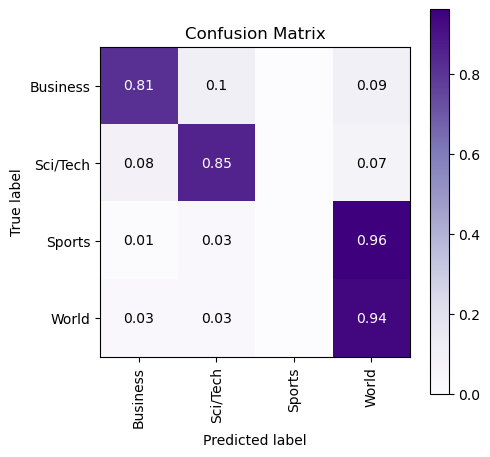

In [17]:
skplt.metrics.plot_confusion_matrix([target_classes[i] for i in Y_actual], [target_classes[i] for i in Y_preds],
                                    normalize=True,
                                    title="Confusion Matrix",
                                    cmap="Purples",
                                    hide_zeros=True,
                                    figsize=(5,5)
                                    );
plt.xticks(rotation=90);